# Linear and Logistic Regression with Regularization and addressing Multicollinearity

###### This project aims to predict total sales per month for OLIST e-commerce website. The dependent variables are freight value and difference in sales between two months. We are predicting total sales by using linear regression and also performing Lasso and Ridge regularization techniques to remove insignificant variables with the least coefficients

###### This project also aims to predict whether a customer will purchase multiple orders from OLIST based on the customer's first purchase predictors. This will be done using Logistic Regression. This can help the company decide which customers are capable of doing multiple purchases and focus on the ones which are one-time purchasers and increase their sales by influencing them to do more than one purchase.

##### Please note: This project is done on a custom conda environment with the following packages:<br>
1) Pandas ver 1.1<br>
2) Numpy<br>
3) Scikitlearn 0.24.1<br>
4) Python version 3.7.6<br>
5) imbalanced-learn 0.7<br>
6)statsmodels<br>

In [4]:
#import neccesarry libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.feature_selection import RFE


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [5]:
#to remove warning and display all columns in the dataframe
import warnings
warnings.filterwarnings('ignore') #remove warnings from outputs
pd.set_option('display.max_columns', 100) #display 100 columns
pd.set_option('display.max_rows', 100)

#### Please note to replace path of CSVs to your local computer paths where these files are downloaded

In [6]:
#read all the datasets into different variables
cust = pd.read_csv('~/Data_mining/DataArchives/olist_customers_dataset.csv') #customer data cust id PK
loc = pd.read_csv('~/Data_mining/DataArchives/olist_geolocation_dataset.csv') #location details zip code PK
order = pd.read_csv('~/Data_mining/DataArchives/olist_order_items_dataset.csv') #orders order id PK
pay = pd.read_csv('~/Data_mining/DataArchives/olist_order_payments_dataset.csv')#payment info Payment id PK
review = pd.read_csv('~/Data_mining/DataArchives/olist_order_reviews_dataset.csv') #reviews review id PK
ord_cust = pd.read_csv('~/Data_mining/DataArchives/olist_orders_dataset.csv') # order and cust id PK
product = pd.read_csv('~/Data_mining/DataArchives/olist_products_dataset.csv')# product id PK
sellers = pd.read_csv('~/Data_mining/DataArchives/olist_sellers_dataset.csv')# seller id PK
prd_name = pd.read_csv('~/Data_mining/DataArchives/product_category_name_translation.csv') #translation data

In [7]:
d_set = order
d_set.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [8]:
d_set = d_set[['shipping_limit_date', 'price', 'freight_value']]
d_set = d_set.sort_values('shipping_limit_date')

In [9]:
d_set['shipping_limit_date'] = pd.to_datetime(d_set['shipping_limit_date'])
d_set.dtypes

shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [10]:
#https://stackoverflow.com/questions/26646191/pandas-groupby-month-and-year
d_set.set_index('shipping_limit_date', inplace=True)
d_set = d_set.resample("M").sum()

In [11]:
d_set.head()

,price,freight_value
shipping_limit_date,,
2016-09-30,194.47,24.05
2016-10-31,49580.55,7364.52
2016-11-30,0.00,0.00
2016-12-31,10.90,8.72
2017-01-31,80124.74,12073.67


> We can observe there are many Outliers, so assuming the months with no sales to be Outliers we remove them

In [12]:
#https://www.geeksforgeeks.org/how-to-drop-rows-in-dataframe-by-conditions-on-column-values/
d_set = d_set.drop(d_set[d_set['price'] == 0.00].index, axis= 0)

> Removing months with too low sum of Monthly prices since they look like outliers

In [13]:
#Remove months with less than 1000 price, they might be outliers
d_set = d_set[d_set['price'] > 1000]

In [14]:
d_set.head()

,price,freight_value
shipping_limit_date,,
2016-10-31,49580.55,7364.52
2017-01-31,80124.74,12073.67
2017-02-28,245982.01,36749.51
2017-03-31,343242.60,53299.79
2017-04-30,308148.32,44697.44


In [15]:
d_set.rename(columns= {'price': 'Total sales'}, inplace= True)
d_set.index.names = ['Monthly Shipping']

In [16]:
d_set.head(2)

,Total sales,freight_value
Monthly Shipping,,
2016-10-31,49580.55,7364.52
2017-01-31,80124.74,12073.67


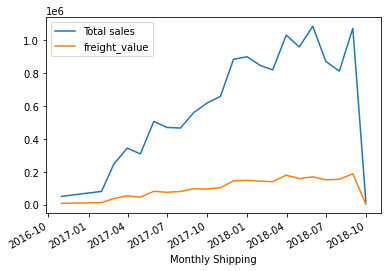

In [17]:
d_set.plot()

In [18]:
# Testing whether the data is Stationary or not
from statsmodels.tsa.stattools import adfuller

In [19]:
test_result= adfuller(d_set['Total sales'])

In [20]:
#https://github.com/krishnaik06/ARIMA-And-Seasonal-ARIMA/blob/master/Untitled.ipynb
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [21]:
adfuller_test(d_set['Total sales'])

ADF Test Statistic : -2.1829965125890682
p-value : 0.21247451728902073
#Lags Used : 1
Number of Observations Used : 20
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


> Data looks like Stationary, but our test says data is non-stationary based on p-value

### Differencing (Making the data Stationary)

In [22]:
d_set['Seasonal First Difference'] = d_set['Total sales'] - d_set['Total sales'].shift(1)

In [23]:
d_set.head()

,Total sales,freight_value,Seasonal First Difference
Monthly Shipping,,,
2016-10-31,49580.55,7364.52,NaN
2017-01-31,80124.74,12073.67,30544.19
2017-02-28,245982.01,36749.51,165857.27
2017-03-31,343242.60,53299.79,97260.59
2017-04-30,308148.32,44697.44,-35094.28


In [24]:
## Again test dickey fuller test
adfuller_test(d_set['Seasonal First Difference'].dropna())

ADF Test Statistic : -4.475210170584723
p-value : 0.0002179473056285036
#Lags Used : 0
Number of Observations Used : 20
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


> p-value reduced significantly, Hence our data is stationary now

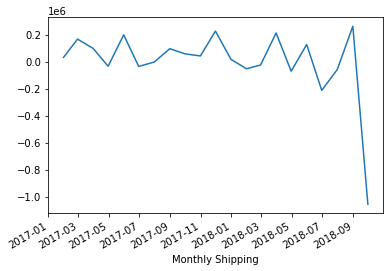

In [25]:
d_set['Seasonal First Difference'].plot()

In [26]:
X = d_set.dropna().drop(['Total sales'], axis= 1)
y = d_set.dropna().drop(['freight_value', 'Seasonal First Difference'], axis= 1)

In [27]:
X.head(2)

,freight_value,Seasonal First Difference
Monthly Shipping,,
2017-01-31,12073.67,30544.19
2017-02-28,36749.51,165857.27


In [28]:
y.head(2)

,Total sales
Monthly Shipping,
2017-01-31,80124.74
2017-02-28,245982.01


In [29]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

In [30]:
X.head() #Data is into the same scales

,0,1
0,-1.747387,0.122620
1,-1.292556,0.637670
2,-0.987498,0.376567
3,-1.146058,-0.127223
4,-0.484914,0.758141


In [31]:
#https://www.kaggle.com/antoinekrajnc/simplest-time-series-using-linear-regression
def TimeSeriesTrainTestSplit(x, y, test_size):
    
        test_index = int(len(X)*(1-test_size))
    
        X_train = X.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = X.iloc[test_index:]
        y_test = y.iloc[test_index:]
        return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

In [32]:
X_train.head()

,0,1
0,-1.747387,0.122620
1,-1.292556,0.637670
2,-0.987498,0.376567
3,-1.146058,-0.127223
4,-0.484914,0.758141


In [33]:
X_test

,0,1
16,1.132942,0.484546
17,0.806779,-0.806763
18,0.863410,-0.220519
19,1.477417,0.999877
20,-1.941844,-4.019418


## Linear Regression

In [34]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [35]:
from sklearn.model_selection import TimeSeriesSplit
ts_cross_val = TimeSeriesSplit(n_splits=5)

In [36]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_mean_squared_error")

In [37]:
cv

array([-1.90360408e+09, -2.06600618e+09, -1.61524235e+07, -9.50810892e+08,
       -1.47053876e+09])

In [38]:
y_pred = regressor.predict(X_test)

In [39]:
y_test

,Total sales
Monthly Shipping,
2018-05-31,1084358.55
2018-06-30,870736.84
2018-07-31,811132.08
2018-08-31,1072147.70
2018-09-30,14502.50


In [40]:
y_pred

array([[1005041.87829122],
       [ 909275.2147516 ],
       [ 924098.5214149 ],
       [1110414.04002306],
       [  64010.6319375 ]])

In [41]:
y1 = y_test.reset_index()

In [42]:
y1

,Monthly Shipping,Total sales
0,2018-05-31,1084358.55
1,2018-06-30,870736.84
2,2018-07-31,811132.08
3,2018-08-31,1072147.70
4,2018-09-30,14502.50


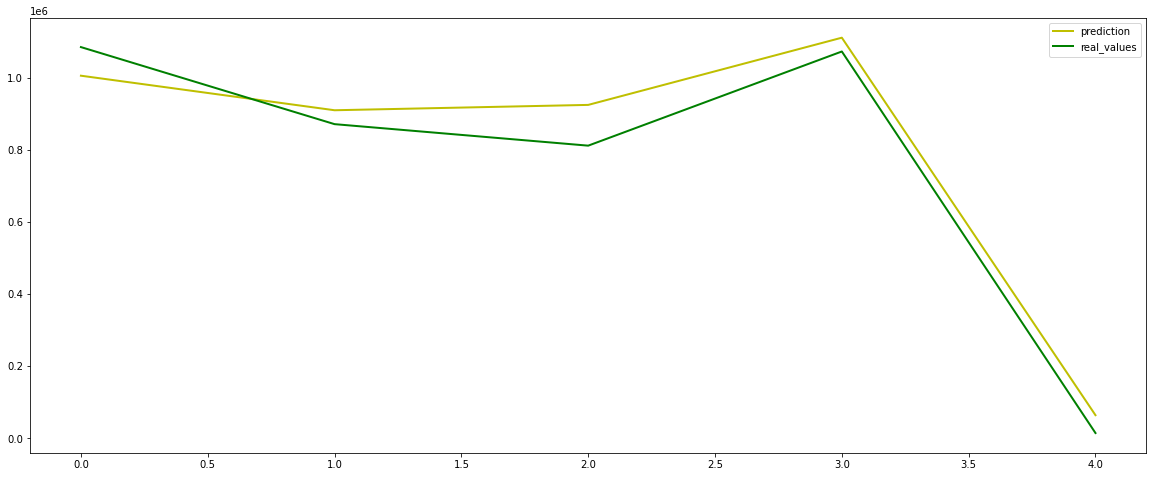

In [43]:
plt.figure(figsize=(20,8))
plt.plot(y_pred, "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

## Regression Evaluation Metrics
Here are three common evaluation metrics for regression problems:

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$
Mean Squared Error (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$
Comparing these metrics:

* MAE is the easiest to understand, because it's the average error.
* MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
* RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.

> All of these are loss functions, because we want to minimize them.

In [44]:
from sklearn import metrics

In [45]:
print('MAE: ', metrics.mean_absolute_error(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE:  63719.19196716291
MSE:  4890625106.419729
RMSE:  69933.00441436596


There is an error of price on an average of 69933 units/currecy, since the amount are in Lakhs, our model might not have performed well, but not bad

In [46]:
# Evaluating the Linear Regression model, R-square
print(regressor.score(X_test, y_test)) 

0.9683548537930171


> We have a very good R-square value, hence almost 96.8% of the variability in Total monthley sales is explained by the predictors

### Ridge(L2) Regression:
#### https://www.geeksforgeeks.org/ml-implementing-l1-and-l2-regularization-using-sklearn/

In [47]:
from sklearn.linear_model import Ridge, Lasso
from statistics import mean 

In [48]:
# List to maintain the different cross-validation scores 
cross_val_scores_ridge = [] 
  
# List to maintain the different values of alpha 
alpha = [] 
  
# Loop to compute the different values of cross-validation scores 
for i in range(1, 9): 
    ridgeModel = Ridge(alpha = i * 0.25) 
    ridgeModel.fit(X_train, y_train) 
    scores = cross_val_score(ridgeModel, X, y, cv = 10) 
    avg_cross_val_score = mean(scores)*100
    cross_val_scores_ridge.append(avg_cross_val_score) 
    alpha.append(i * 0.25) 
  
#Loop to print the different values of cross-validation scores

for i in range(0, len(alpha)): 
    print(str(alpha[i])+' : '+str(cross_val_scores_ridge[i]))

0.25 : -1201.440227086318
0.5 : -1377.9712914206625
0.75 : -1584.0227227782223
1.0 : -1816.6617116873244
1.25 : -2073.2497776037144
1.5 : -2351.408919597267
1.75 : -2648.992274971372
2.0 : -2964.058589541308


In [49]:
# Building and fitting the Ridge Regression model 
ridgeModelChosen = Ridge(alpha = 2) 
ridgeModelChosen.fit(X_train, y_train) 
  
# Evaluating the Ridge Regression model 
print(ridgeModelChosen.score(X_test, y_test))

0.9523062120170963


### Lasso(L1) Regression:

In [50]:
# List to maintain the cross-validation scores 
cross_val_scores_lasso = [] 
  
# List to maintain the different values of Lambda 
Lambda = [] 
  
# Loop to compute the cross-validation scores 
for i in range(1, 9): 
    lassoModel = Lasso(alpha = i * 0.25, tol = 0.0925) 
    lassoModel.fit(X_train, y_train) 
    scores = cross_val_score(lassoModel, X, y, cv = 10) 
    avg_cross_val_score = mean(scores)*100
    cross_val_scores_lasso.append(avg_cross_val_score) 
    Lambda.append(i * 0.25) 
  
# Loop to print the different values of cross-validation scores 
for i in range(0, len(alpha)): 
    print(str(alpha[i])+' : '+str(cross_val_scores_lasso[i])) 

0.25 : -1037.5923493033204
0.5 : -1037.5968970711674
0.75 : -1037.6014449281101
1.0 : -1037.6059928741602
1.25 : -1037.6105409093084
1.5 : -1037.6150890335687
1.75 : -1037.6196372469224
2.0 : -1037.62418554938


In [51]:
# Building and fitting the Lasso Regression Model 
lassoModelChosen = Lasso(alpha = 2, tol = 0.0925) 
lassoModelChosen.fit(X_train, y_train) 
  
# Evaluating the Lasso Regression model 
print(lassoModelChosen.score(X_test, y_test)) 

0.9683665054854449


### Comparing and Visualizing the results

In [52]:
print("Linear Regreesion :", regressor.score(X_test, y_test)) 
print("Ridge Regreesion :", ridgeModelChosen.score(X_test, y_test)) 
print("Lasso Regression :", lassoModelChosen.score(X_test, y_test)) 

Linear Regreesion : 0.9683548537930171
Ridge Regreesion : 0.9523062120170963
Lasso Regression : 0.9683665054854449


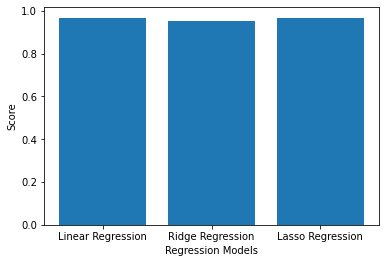

In [53]:
# Plotting the scores 
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression'] 
scores = [regressor.score(X_test, y_test), 
         ridgeModelChosen.score(X_test, y_test), 
         lassoModelChosen.score(X_test, y_test)]

plt.bar(models, scores) 
plt.xlabel('Regression Models') 
plt.ylabel('Score') 
plt.show() 

## Prepare the data for Logistic regression

In [54]:
#change the data type of date formats to datetime
ord_cust['order_purchase_timestamp'] = pd.to_datetime(ord_cust['order_purchase_timestamp'])
ord_cust['order_delivered_customer_date'] = pd.to_datetime(ord_cust['order_delivered_customer_date'])

In [55]:
#create a new column to calculate the numbr of days between order placed and order delivered to the customer
ord_cust['num_days_delivered_cust'] = (ord_cust['order_delivered_customer_date'] - ord_cust['order_purchase_timestamp'])

##### Create a dataframe to feed the algorithm

In [56]:
#to count the orders per customer unique id
main_df = pd.DataFrame(cust.groupby('customer_unique_id').size(),columns = ['num_of_orders'])
main_df = main_df.reset_index()

##### Merge all the dataframe into one and then select the features that may depend on our target variable

In [57]:
main_df = main_df.merge(cust,left_on='customer_unique_id',right_on='customer_unique_id')
main_df = main_df.merge(ord_cust,left_on='customer_id',right_on='customer_id')
main_df = order.merge(main_df,left_on='order_id',right_on='order_id')
main_df = main_df.merge(product,left_on='product_id',right_on='product_id')
main_df = main_df.merge(pay,left_on='order_id',right_on='order_id')
main_df = main_df.merge(review,left_on='order_id',right_on='order_id')
main_df = main_df.merge(sellers,left_on='seller_id',right_on='seller_id')
main_df = main_df.merge(prd_name,left_on='product_category_name',right_on='product_category_name')

In [58]:
#select columns to include in our regression model
main_df = pd.concat([main_df['customer_unique_id'],main_df['num_of_orders'],main_df['customer_state'],main_df['order_status'],main_df['order_purchase_timestamp'],main_df['num_days_delivered_cust'],main_df['payment_type'],main_df['payment_value'],main_df['review_score'],main_df['product_category_name_english']],axis=1,keys=['cust_id','num_of_orders','cust_loc','order_status','order_purchase_timestamp','num_days_delivered_cust','payment_type','payment_value','review_score','prd_name'])

#### Create the target variable. <br>
-> 0 indicates the customer has only made one order<br>
-> 1 indicates the customer has made multiple orders

In [59]:
main_df['multiple_order'] = pd.Series(dtype='int64')
main_df['multiple_order'] = np.where(main_df['num_of_orders']==1,0,1)

Select data of only the first purchases made by all the customers

In [60]:
main_df = pd.DataFrame(main_df.groupby(['cust_id','cust_loc','order_status','num_days_delivered_cust','payment_type','payment_value','review_score','prd_name','multiple_order'])['order_purchase_timestamp'].min())
main_df = main_df.reset_index()

Reorganizing the columns for better understnading and ease of introducing into the algorithm

In [61]:
columns = ['multiple_order','cust_loc','num_days_delivered_cust','order_status','payment_type','payment_value','review_score','prd_name']
main_df = main_df.reindex(columns=columns)

In [62]:
#just include days data(not days and time) in the column
a=[]
for index,value in enumerate(main_df['num_days_delivered_cust']):
    a.append(value.days)
main_df['num_days_delivered_cust'] = a

#### Reorganizing Product category and customer location to fewer classes before one-hot encoding

In [63]:
main_df['prd_cat'] = pd.Series(dtype='object')
main_df['prd_cat'] = np.where(((main_df['prd_name'] == 'bed_bath_table') | (main_df['prd_name'] == 'home_confort') |
                              (main_df['prd_name'] == 'housewares') | (main_df['prd_name'] == 'furniture_living_room') |
                              (main_df['prd_name'] == 'office_furniture' )| (main_df['prd_name'] == 'furniture_decor') |
                              (main_df['prd_name'] == 'kitchen_dining_laundry_garden_furniture' )| 
                               (main_df['prd_name'] == 'furniture_bedroom') | 
                               (main_df['prd_name'] == 'furniture_mattress_and_upholstery') | 
                               (main_df['prd_name'] == 'home_comfort_2')) , 'FURNITURE' , main_df['prd_cat'])
main_df['prd_cat'] = np.where(((main_df['prd_name'] == 'garden_tools') | 
                               (main_df['prd_name'] == 'construction_tools_construction') |
                              (main_df['prd_name'] == 'home_construction') | 
                               (main_df['prd_name'] == 'construction_tools_safety' )|
                              (main_df['prd_name'] == 'construction_tools_lights') | 
                               (main_df['prd_name'] == 'costruction_tools_garden') |
                              (main_df['prd_name'] == 'costruction_tools_tools')) ,'CONSTRUCTION',main_df['prd_cat'])
main_df['prd_cat'] = np.where(((main_df['prd_name'] == 'telephony') | (main_df['prd_name'] == 'computers_accessories') |
                              (main_df['prd_name'] == 'home_appliances') | (main_df['prd_name'] == 'small_appliances' )|
                              (main_df['prd_name'] == 'electronics') | (main_df['prd_name'] == 'consoles_games') | 
                              (main_df['prd_name'] == 'home_appliances_2') | (main_df['prd_name'] == 'fixed_telephony') |
                              (main_df['prd_name'] == 'audio') | (main_df['prd_name'] == 'dvds_blu_ray') |
                              (main_df['prd_name'] == 'computers') | (main_df['prd_name'] == 'air_conditioning') |
                              (main_df['prd_name'] == 'tablets_printing_image' )| 
                               (main_df['prd_name'] == 'cds_dvds_musicals') |
                              (main_df['prd_name'] == 'small_appliances_home_oven_and_coffee' )| 
                               (main_df['prd_name'] == 'music')) , 'APPLIANCES' , main_df['prd_cat'])
main_df['prd_cat'] = np.where(((main_df['prd_name'] == 'health_beauty') | (main_df['prd_name'] == 'sports_leisure') |
                              (main_df['prd_name'] == 'fashion_bags_accessories') | (main_df['prd_name'] == 'health_beauty') |
                              (main_df['prd_name'] == 'health_beauty') | (main_df['prd_name'] == 'luggage_accessories' )|
                              (main_df['prd_name'] == 'fashion_underwear_beach') | (main_df['prd_name'] == 'perfumery' )|
                              (main_df['prd_name'] == 'cool_stuff') | (main_df['prd_name'] == 'fashion_shoes') |
                              (main_df['prd_name'] == 'fashion_male_clothing' )| (main_df['prd_name'] == 'fashion_sport') |
                              (main_df['prd_name'] == 'fashio_female_clothing') | 
                               (main_df['prd_name'] == 'fashion_childrens_clothes')),'FASHION',main_df['prd_cat'])
main_df['prd_cat'] = np.where(((main_df['prd_name'] == 'stationery' )| (main_df['prd_name'] == 'musical_instruments') |
                              (main_df['prd_name'] == 'toys') | (main_df['prd_name'] == 'watches_gifts') |
                              (main_df['prd_name'] == 'drinks') | (main_df['prd_name'] == 'books_general_interest') |
                              (main_df['prd_name'] == 'christmas_supplies') | (main_df['prd_name'] == 'baby') |
                              (main_df['prd_name'] == 'pet_shop') | (main_df['prd_name'] == 'flowers') |
                              (main_df['prd_name'] == 'art') | (main_df['prd_name'] == 'food_drink') |
                              (main_df['prd_name'] == 'food') | (main_df['prd_name'] == 'books_technical') |
                              (main_df['prd_name'] == 'books_imported') | (main_df['prd_name'] == 'party_supplies' )|
                              (main_df['prd_name'] == 'diapers_and_hygiene') | 
                               (main_df['prd_name'] == 'arts_and_craftmanship') | (main_df['prd_name'] == 'la_cuisine')),
                              'HOUSEHOLD',main_df['prd_cat'])
main_df['prd_cat'] = np.where(((main_df['prd_name'] == 'auto') | (main_df['prd_name'] == 'industry_commerce_and_business') |
                              (main_df['prd_name'] == 'signaling_and_security') | (main_df['prd_name'] == 'market_place') |
                              (main_df['prd_name'] == 'cine_photo') | (main_df['prd_name'] == 'agro_industry_and_commerce') |
                              (main_df['prd_name'] == 'security_and_services')),'INDUSTRY',main_df['prd_cat'])

In [64]:
main_df['cust_region'] = pd.Series(dtype='object')
main_df['cust_region'] = np.where(((main_df['cust_loc'] == 'RO') | (main_df['cust_loc'] == 'AC') |
                                   (main_df['cust_loc'] == 'AM') | (main_df['cust_loc'] == 'RR') |
                                   (main_df['cust_loc'] == 'PA') | (main_df['cust_loc'] == 'AP') |
                                   (main_df['cust_loc'] == 'TO')),'NORTH' , main_df['cust_region'])
main_df['cust_region'] = np.where(((main_df['cust_loc'] == 'MA') | (main_df['cust_loc'] == 'PI') |
                                   (main_df['cust_loc'] == 'CE') | (main_df['cust_loc'] == 'RN') |
                                   (main_df['cust_loc'] == 'PB') | (main_df['cust_loc'] == 'PE') |
                                   (main_df['cust_loc'] == 'AL') | (main_df['cust_loc'] == 'SE') |
                                  (main_df['cust_loc'] == 'BA')),'NORTHEAST' , main_df['cust_region'])        
main_df['cust_region'] = np.where(((main_df['cust_loc'] == 'MG') | (main_df['cust_loc'] == 'ES') |
                                   (main_df['cust_loc'] == 'RJ') | (main_df['cust_loc'] == 'SP')),
                                   'SOUTHEAST' , main_df['cust_region'])
main_df['cust_region'] = np.where(((main_df['cust_loc'] == 'PR') | (main_df['cust_loc'] == 'SC') |
                                   (main_df['cust_loc'] == 'RS')) ,'SOUTH' , main_df['cust_region'])
main_df['cust_region'] = np.where(((main_df['cust_loc'] == 'MS') | (main_df['cust_loc'] == 'MT') |
                                   (main_df['cust_loc'] == 'GO') | (main_df['cust_loc'] == 'DF')),
                                   'MIDWEST' , main_df['cust_region'])

In [65]:
#Drop older columns
main_df = main_df.drop(columns=['cust_loc','prd_name'],axis=1)

In [66]:
#one-hot encode the below variables
main_df = pd.get_dummies(main_df, columns=['order_status','payment_type','prd_cat','cust_region'])

#### The final dataframe

In [67]:
main_df.head()

,multiple_order,num_days_delivered_cust,payment_value,review_score,order_status_canceled,order_status_delivered,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,prd_cat_APPLIANCES,prd_cat_CONSTRUCTION,prd_cat_FASHION,prd_cat_FURNITURE,prd_cat_HOUSEHOLD,prd_cat_INDUSTRY,cust_region_MIDWEST,cust_region_NORTH,cust_region_NORTHEAST,cust_region_SOUTH,cust_region_SOUTHEAST
0,0,6,141.90,5,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,3,27.19,4,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,25,86.22,3,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,20,43.62,4,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0,13,196.89,5,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1


## SMOTE Algorithm
This is used when there is imbalance between the proportion of the classes in the target variable. This algorithm does up-sampling the class which has lower number of occurances in the data. Because we have fewer examples of customer having more than one order, we will apply this algorithm to take up random samples and equalize both the classes.

In [68]:
main_df['multiple_order'].value_counts()

0    93150
1     6621
Name: multiple_order, dtype: int64

In [69]:
X = main_df.loc[:, main_df.columns != 'multiple_order']
y = main_df.loc[:, main_df.columns == 'multiple_order']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['multiple_order'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of one time customers in oversampled data",len(os_data_y[os_data_y['multiple_order']==0]))
print("Number of multiple order customers",len(os_data_y[os_data_y['multiple_order']==1]))
print("Proportion of one-time customers data in oversampled data is ",
      len(os_data_y[os_data_y['multiple_order']==0])/len(os_data_X))
print("Proportion of multiple-order customers data in oversampled data is ",
      len(os_data_y[os_data_y['multiple_order']==1])/len(os_data_X))

length of oversampled data is  130344
Number of one time customers in oversampled data 65172
Number of multiple order customers 65172
Proportion of one-time customers data in oversampled data is  0.5
Proportion of multiple-order customers data in oversampled data is  0.5


## Data Modeling using scikit-learn LogisticRegression()

In [70]:
#Divide the data into train and test
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.33, random_state=42)
logreg = LogisticRegression() #initialize the model
logreg.fit(X_train, y_train) #fit the model on training data

LogisticRegression()

In [71]:
y_pred = logreg.predict(X_test) #calculate predicted values and calculate the accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


## Metrics

In [72]:
#Coefficient of Determination
r2Score = r2_score(y_test,y_pred)
print('Coefficient of Determination for logistic regression classifier on test set: {:.2f}'.format(r2Score))

Coefficient of Determination for logistic regression classifier on test set: 0.46


In [73]:
#Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm

,0,1
0,21192,491
1,5324,16007


In [74]:
#Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88     21683
           1       0.97      0.75      0.85     21331

    accuracy                           0.86     43014
   macro avg       0.88      0.86      0.86     43014
weighted avg       0.88      0.86      0.86     43014



## L1 Regularization

In [75]:
C = [10, 1, .1, .001]

for c in C:
    clf_l1 = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf_l1.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf_l1.coef_)
    print('Training accuracy:', clf_l1.score(X_train, y_train))
    print('Test accuracy:', clf_l1.score(X_test, y_test))
    print('')

C: 10
Coefficient of each feature: [[-2.68811175e-02 -1.20584569e-03 -4.25681781e-02  0.00000000e+00
   1.28306499e+01 -8.51385471e+00 -7.96773365e+00 -9.25364401e+00
  -7.98377491e+00 -9.71306277e+00 -1.00789173e+01 -9.42113533e+00
  -9.10831173e+00 -9.97326329e+00 -1.05787428e+01 -8.99025671e+00
  -9.13308342e+00 -8.99107559e+00 -8.87329865e+00 -8.18695264e+00]]
Training accuracy: 0.8738119775563953
Test accuracy: 0.8745059747989027

C: 1
Coefficient of each feature: [[-2.68833291e-02 -1.20101855e-03 -4.26360120e-02  0.00000000e+00
   1.13089503e+01 -7.92564942e+00 -7.38041017e+00 -8.64791134e+00
  -7.39484111e+00 -8.83336751e+00 -9.19707087e+00 -8.54180292e+00
  -8.22904654e+00 -9.09351135e+00 -9.69427675e+00 -8.26925127e+00
  -8.40040245e+00 -8.27138368e+00 -8.15446599e+00 -7.46943368e+00]]
Training accuracy: 0.8738119775563953
Test accuracy: 0.8745059747989027

C: 0.1
Coefficient of each feature: [[-2.58346673e-02 -1.13223759e-03 -3.76943292e-02  0.00000000e+00
   8.02988206e+00 -

## L2 Regularization

In [76]:
C = [10, 1, .1, .001]

for c in C:
    clf_l2 = LogisticRegression(penalty='l2', C=c, solver='liblinear')
    clf_l2.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf_l2.coef_)
    print('Training accuracy:', clf_l2.score(X_train, y_train))
    print('Test accuracy:', clf_l2.score(X_test, y_test))
    print('')

C: 10
Coefficient of each feature: [[-2.67786483e-02 -1.19551848e-03 -4.28139075e-02 -2.90502316e-03
   1.07892545e+01 -7.47717554e+00 -6.93161672e+00 -8.18943295e+00
  -6.94793398e+00 -8.32645004e+00 -8.68613564e+00 -8.03464276e+00
  -7.72193616e+00 -8.58664996e+00 -9.18622350e+00 -7.78865464e+00
  -7.93510802e+00 -7.79270641e+00 -7.67354623e+00 -6.98896039e+00]]
Training accuracy: 0.8738119775563953
Test accuracy: 0.8745059747989027

C: 1
Coefficient of each feature: [[-2.61783678e-02 -1.15243633e-03 -3.95415857e-02 -2.25683047e-03
   8.74833970e+00 -6.15618987e+00 -5.61482285e+00 -6.77005494e+00
  -5.62290438e+00 -6.91700879e+00 -7.26884599e+00 -6.62869153e+00
  -6.31690474e+00 -7.17650876e+00 -7.74304634e+00 -6.43473664e+00
  -6.50589670e+00 -6.44580400e+00 -6.32928805e+00 -5.65078055e+00]]
Training accuracy: 0.8738119775563953
Test accuracy: 0.8745059747989027

C: 0.1
Coefficient of each feature: [[-2.23872352e-02 -9.75197749e-04 -2.09577710e-02 -1.85814152e-03
   5.69585189e+00 -

## ROC Curve

In [77]:
p_pred_proba_l2 = clf_l2.predict_proba(X_test)[::,1]
fpr_l2, tpr_l2, _ = roc_curve(y_test,  p_pred_proba_l2)
auc_l2 = roc_auc_score(y_test, p_pred_proba_l2)

In [78]:
p_pred_proba_l1 = clf_l1.predict_proba(X_test)[::,1]
fpr_l1, tpr_l1, _ = roc_curve(y_test,  p_pred_proba_l1)
auc_l1 = roc_auc_score(y_test, p_pred_proba_l1)

In [79]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

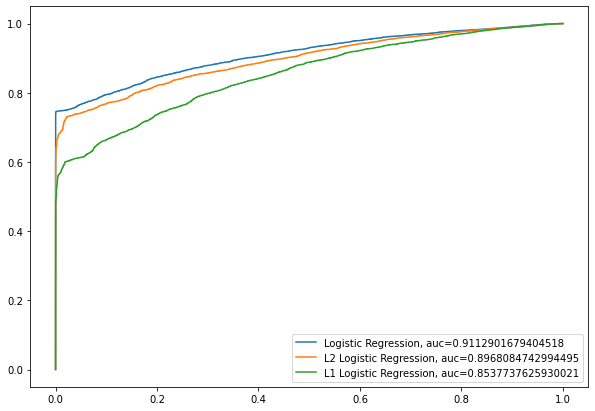

In [80]:
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))
plt.plot(fpr_l2,tpr_l2,label="L2 Logistic Regression, auc="+str(auc_l2))
plt.plot(fpr_l1,tpr_l1,label="L1 Logistic Regression, auc="+str(auc_l1))


plt.legend(loc=4)
plt.show()

## Addressing multicollinearity using Variance inflation factor (VIF)

In [81]:
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

                     feature       VIF
0    num_days_delivered_cust  1.269074
1              payment_value  1.021900
2               review_score  1.131484
3      order_status_canceled       inf
4     order_status_delivered       inf
5        payment_type_boleto       inf
6   payment_type_credit_card       inf
7    payment_type_debit_card       inf
8       payment_type_voucher       inf
9         prd_cat_APPLIANCES       inf
10      prd_cat_CONSTRUCTION       inf
11           prd_cat_FASHION       inf
12         prd_cat_FURNITURE       inf
13         prd_cat_HOUSEHOLD       inf
14          prd_cat_INDUSTRY       inf
15       cust_region_MIDWEST       inf
16         cust_region_NORTH       inf
17     cust_region_NORTHEAST       inf
18         cust_region_SOUTH       inf
19     cust_region_SOUTHEAST       inf


When a dummy variable that represents more than two categories has a high VIF, multicollinearity does not necessarily exist. The variables will always have high VIFs if there is a small portion of cases in the category, regardless of whether the categorical variables are correlated to other variables. In this case we can safely ignore the multicollinearity.

## Recursive feature elimination
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [82]:
rfe = RFE(logreg, 10)
rfe = rfe.fit(os_data_X, os_data_y.values)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False  True  True  True  True  True  True  True
  True  True  True False False False False False]
[ 9 11  8 10  7  1  1  1  1  1  1  1  1  1  1  4  2  3  5  6]


This RFE algorithm is giving the top 10 features that we can include in our model to get a better accuracy rate. We can re train our model just using the features with the highest ranking and calculate the accuracy.